# Cosmic Ray Flux Study

## (Fill in science story here)

### 1) Import Parsl

In [1]:
import parsl
from parsl.config import Config
from parsl.executors.threads import ThreadPoolExecutor
from parsl.app.app import bash_app,python_app
from parsl import File

### 1.5) Import other stuff

In [2]:
#import sys
import matplotlib.pyplot as plt

### 2) Configure Parsl

In [2]:
config = Config(
    executors=[ThreadPoolExecutor()],
    lazy_errors=True
)
parsl.load(config)

### 3) Define Parsl Apps that call each of the data transformation scripts we'll use

In [3]:
# For data processing:
@bash_app
def WireDelay(threshIn='', outputs=[], geoDir='', daqId='', fw='', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/WireDelay.pl %s %s %s %s %s' %(threshIn, outputs[0], geoDir, daqId, fw)

@bash_app
def Combine(inputs=[], outputs=[], stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Combine.pl ' + ' '.join(inputs) + ' ' + str(outputs[0])

@bash_app
def SingleChannel(inputs=[], outputs=[], channel='1'):
    return 'perl ./perl/SingleChannel.pl %s %s %s' % (inputs[0], outputs[0], channel)
    
@bash_app
def Sort(inputs=[], outputs=[], key1='1', key2='1', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Sort.pl %s %s %s %s' % (inputs[0], outputs[0], key1, key2)

@bash_app
def Flux(inputs=[], outputs=[], binWidth='600', geoDir='geo/', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ./perl/Flux.pl %s %s %s %s' % (inputs[0], outputs[0], binWidth, geoDir)

# For making plots:
@bash_app
def Plot(inputs=[], outputs=[], ptype='', caption='Plot Caption', title='Plot Title', 
         x=[0,1,"x-axis"], y=[0,1,"y-axis"], z=[0,1,"z-axis"], stdout='stdout.txt', stderr='stderr.txt'):
    '''Two output files: outputs[0] is a text list of parameters and outputs[1] is the plot image'''
    return 'perl ./perl/Plot.pl -file %s -param %s -svg %s -type %s -title %s -xlabel %s -ylabel %s -zlabel %s -caption %s -lowx %s -highx %s -lowy %s -highy %s -lowz %s -highz %s' % (inputs[0], outputs[0], outputs[1], ptype, title, x[2], y[2], z[2], caption, x[0], x[1], y[0], y[1], z[0], z[1])

@bash_app
def SVG2PNG(inputs=[], outputs=[], height='', stdout='stdout.txt', stderr='stderr.txt'):
    '''Converts an input SVG file into a PNG for display'''
    """Unlike other Apps, there is no SVG2PNG.pl script.  Near as I can tell, Swift's old tc.data
        file linked this App to the command-line utility `rsvg`.  See if that works."""
    #return 'perl ./perl/SVG2PNG.pl -h %s -w %s %s %s' % (height, height, svgIn, pngOut)
    return 'rsvg -h %s -w %s %s %s' % (height, height, inputs[0], outputs[0])


### 4) Define input parameters

In [4]:
# For WireDelay
thresholdAll = ('files/6119.2016.0104.1.thresh', 'files/6203.2016.0104.1.thresh')
wireDelayData = ('6119.2016.0104.1.wd', '6203.2016.0104.1.wd')
geoDir = './geo'
detectors = ('6119', '6203')
firmwares = ('1.12', '1.12')

# For Combine
combineOut = 'combineOut'

# For SingleChannel
singlechannel_channel = '1'
singleChannelOut = 'singleChannelOut'

# For Sort
sort_sortKey1 = '2'
sort_sortKey2 = '3'
sortOut = 'sortOut'

# For Flux
binWidth = '600'
geoFiles = ['geo/6119/6119.geo', 'geo/6203/6203.geo']
fluxOut = 'fluxOut'

# For Plot
paramOut = 'PlotParametersOut'
svgOut = 'Plot.svg'
plotType = '3'
title = 'Flux as a Function of Time'
caption = 'Plot Caption'
#xLabel = 'Time'
#xLow = '0'
#xHi = '1'
xAxis = ['0.99999','1.00001','Time']
#yLabel = 'Flux (events/m^2/min)'
#yLow = '0'
#yHi = '1'
yAxis = ['0','100','Flux']
#zLabel = 'N/A'
#zLow = '0'
#zHi = '1'
zAxis = ['','','']

# For SVG2PNG
pngOut = 'Plot.png'
height = '600'

### 5) The Workflow

With everything above defined, we can now define the workflow itself by calling Apps using the above input parameters.

#### i) Wire Delay
First, we'll call the WireDelay script once for each input threshold file.  The [WireDelay](http://localhost:8888/notebooks/Analysis/script_WireDelay.ipynb) script is straightforward: it takes all time values in the input file and corrects them to account for the time it takes for the muon event signal to travel from the detector panel to the DAQ.  This time delay depends on the length of the cable connecting the two, and this (constant) value is stored in the detector's geometry file.

The output of the `WireDelay.pl` script is nearly identical in format to the input threshold files, so we have the script output to filenames ending with the `.wd` extension so we can tell which files the delay has been applied to.

In [5]:
WireDelay_futures = []
for i in range(len(thresholdAll)):
        WireDelay_futures.append(WireDelay(threshIn=thresholdAll[i], outputs=[wireDelayData[i]], 
                                           geoDir=geoDir, daqId=detectors[i], fw=firmwares[i]))
        
WireDelay_outputs = [i.outputs[0] for i in WireDelay_futures]

#### ii) Combine
Next, we combine all of the `.wd` files generated by the WireDelay script into a single file.  Naturally, the script that does this is called [Combine](http://localhost:8888/notebooks/Analysis/script_Combine.ipynb).

In [6]:
Combine_future = Combine(inputs=WireDelay_outputs, outputs=[combineOut])

**Exercise 1)** Would it make a difference in the resulting data file if we called `Combine.pl` before calling `WireDelay.pl`?  If so, what difference do you think it would make?

_Write your answer below:_

**Exercise 2)** Design a way to adapt the code presented here to determine whether or not your answer to Exercise 1) is correct, and then try it.  Did you find the result you expected?

_Write and program your answer below, adding additional cells if necessary:_

#### iii) Single Channel
The [SingleChannel](http://localhost:8888/notebooks/Analysis/script_SingleChannel.ipynb) script selects input data from one of the four detector channels, writing it to the output file and discarding the rest.

In [7]:
SingleChannel_future = SingleChannel(inputs=Combine_future.outputs, outputs=[singleChannelOut], 
                                     channel=singlechannel_channel)

**Exercise 3)** In this example, the input to `SingleChannel` is the file `combineOut`, and the output file is `singleChannelOut`.  Relative to `combineOut`, about how many lines would you expect the file `singleChannelOut` to be?

_Write your answer below:_

**Exercise 4)** Check your answer to Exercise 3) (_hint_: the UNIX shell command to see the number of lines in a file is `wc -l`.  Do you remember how to run a shell command from within a Jupyter Notebook?)

_Write and program your answer below, adding additional cells if necessary:_

#### iv) Sort
The [Sort](http://localhost:8888/notebooks/Analysis/script_Sort.ipynb) script, as you might guess, sorts the input data according to the column parameters we give it.  `Sort` can be more complex than some of the preceding Apps, however, since for most data files there are multiple combinations of primary and secondary sorting that give different results.

In [8]:
Sort_future = Sort(inputs=SingleChannel_future.outputs, outputs=[sortOut], 
                   key1=sort_sortKey1, key2=sort_sortKey2)

In this example, we've used `key1=2` and `key2=3`.

**Exercise 5)** Using your knowledge of the cosmic ray data format and any of the reference links for individual scripts ([WireDelay](http://localhost:8888/notebooks/Analysis/script_WireDelay.ipynb), [Combine](http://localhost:8888/notebooks/Analysis/script_Combine.ipynb), [SingleChannel](http://localhost:8888/notebooks/Analysis/script_SingleChannel.ipynb), and [Sort](http://localhost:8888/notebooks/Analysis/script_Sort.ipynb)), explain why we've chosen this combination of sort columns in preparation for inputting data into the `Flux` script.

_Write your answer below:_

#### v) Flux

Finally, we reach the main event of the Flux Study, the [Flux](http://localhost:8888/notebooks/Analysis/script_Flux.ipynb) App itself, which sorts the cosmic ray muon events in its input file into time bins and outputs the total flux for each bin.

In [9]:
Flux_future = Flux(inputs=Sort_future.outputs, outputs=[fluxOut], binWidth=binWidth, geoDir=geoDir)

The output file `fluxOut` now has the data we're looking for: the total flux of cosmic ray muons represented by the original threshold data files, complete with statistical uncertainties, and sorted into time bins of our choosing.  Take a look:

In [5]:
!head -10 fluxOut

#dba5ecdadabca58ac715b42705a22d67
#md5_hex(1538770992 1540579219 sortOut fluxOut 600 ./geo)
01/04/2016 17:58:07 185135.623870 489.010758
01/04/2016 18:08:07 211609.403255 522.806403
01/04/2016 18:18:07 212983.725136 524.501369
01/04/2016 18:28:07 216491.862568 528.803359
01/04/2016 21:08:07 90632.911392 342.149872
01/04/2016 21:18:07 91066.907776 342.968087
01/04/2016 21:28:07 88716.094033 338.512432
01/04/2016 21:38:07 93562.386980 347.635455


#### vi) Plot
The data portion of the study may be complete, but we might like to have a better representation of the output than a plaintext table of data.  Fortunately, we can forward the output of `Flux` to the [Plot](http://localhost:8888/notebooks/Analysis/script_Plot.ipynb) App, which will create a graphical plot of the data and output it as an SVG file.

In [11]:
Plot_future = Plot(inputs=Flux_future.outputs, outputs=[paramOut,svgOut], ptype=plotType, caption=caption, 
                   title=title, x=xAxis, y=yAxis, z=zAxis)

_Open the file here_

#### vii) SVG2PNG
An SVG format of the plot is useful, but for good measure we might like to have a PNG version that's easier to display on the web.  The [SVG2PNG](http://localhost:8888/notebooks/Analysis/script_SVG2PNG.ipynb) App accomplishes that for us in short order:

In [12]:
SVG_future = SVG2PNG(inputs=[Plot_future.outputs[1]], outputs=[pngOut], height=height)

Let's see how it turned out:

_Open the file here_

Lastly, we'll define a future for the `SVG2PNG` App call that we can test to see if it's completed properly.  Since all Apps in the workflow feed their outputs in a chain that ends at `SVG2PNG`, knowing it's complete means knowing the whole workflow is complete:

In [13]:
x = SVG_future.result()

print("Call to SVG2PNG completed with exit code:", x)

Call to SVG2PNG completed with exit code: 0


#### viii) Plotting with matplotlib

Instead of using the `Plot` and `SVG2PNG` scripts to create static plot images, we can use Python's `matplotlib` package along with its `pyplot` module to create and display dynamic graphs.

First, we'll read in the output file `fluxOut`:

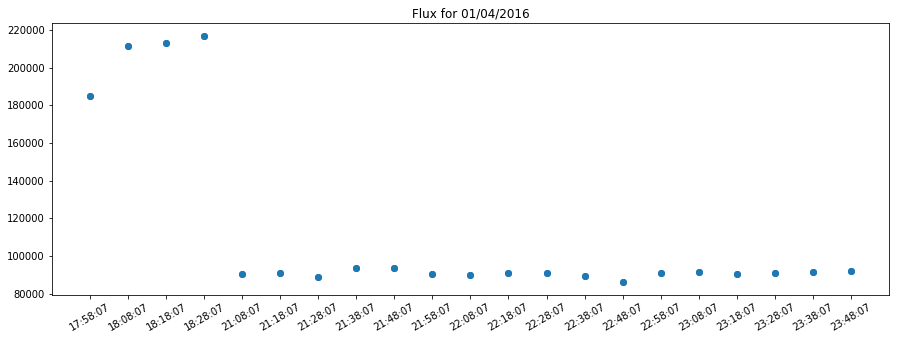

In [65]:
with open("fluxOut") as flux:
    # A list with each line of 'fluxOut' as one element
    lines = flux.readlines()
    # Remove the first two lines, which are comments
    lines = lines[2:]
    # Get the date
    date=str(lines[0].split()[0])
    
    # Split each line into x, y, and uncertainty arrays:
    x = [(line.split()[1]) for line in lines]
    y = [float(line.split()[2]) for line in lines]
    dy = [float(line.split()[3]) for line in lines]

#print(x)
#print(y)
#print(len(y))
    
# Make the output plot bigger:
#scale=15
#plt.rcParams["figure.figsize"]=[scale,scale]
plt.rcParams["figure.figsize"]=[15,5]

# Slant tick-labels on x-axis for readability
plt.xticks(rotation=30)

# Add a title
plt.title("Flux for " + date)

plt.scatter(x,y)

# Add error bars
#   Amplify error bars just to see if they're really there:
#   dy = [20*i for i in dy]
plt.errorbar(x,y,yerr=dy,linestyle="None",fmt='o')
plt.show()

**_The Workflow Summarized_**

When we stop and consider the role of each App in the Flux Study workflow, as we did above, it's easy to lose track of the big picture.  For reference, this notebook's workflow is copied below, condensed into a single cell for readability (and commented out, of course, so that we don't run it twice when running the notebook!) 

In [ ]:
"""
WireDelay_futures = []
for i in range(len(thresholdAll)):
        WireDelay_futures.append(WireDelay(threshIn=thresholdAll[i], outputs=[wireDelayData[i]], 
                                           geoDir=geoDir, daqId=detectors[i], fw=firmwares[i]))
        
WireDelay_outputs = [i.outputs[0] for i in WireDelay_futures]

Combine_future = Combine(inputs=WireDelay_outputs, outputs=[combineOut])

SingleChannel_future = SingleChannel(inputs=Combine_future.outputs, outputs=[singleChannelOut], 
                                     channel=singlechannel_channel)

Sort_future = Sort(inputs=SingleChannel_future.outputs, outputs=[sortOut], 
                   key1=sort_sortKey1, key2=sort_sortKey2)

Flux_future = Flux(inputs=Sort_future.outputs, outputs=[fluxOut], binWidth=binWidth, geoDir=geoDir)

Plot_future = Plot(inputs=Flux_future.outputs, outputs=[paramOut,svgOut], ptype=plotType, caption=caption, 
                   title=title, x=xAxis, y=yAxis, z=zAxis)

SVG_future = SVG2PNG(inputs=[Plot_future.outputs[1]], outputs=[pngOut], height=height)

x = SVG_future.result()

print("Call to SVG2PNG completed with exit code:", x)
"""